# CXB with Metadata Assets
This project automates the extraction, classification, and validation of metadata from PDFs using AI-powered processing. It integrates Google Cloud Storage for document management and leverages Optical Character Recognition (OCR) and Large Language Models (LLMs) to extract key information. The system distinguishes between digital and scanned PDFs, applies appropriate text extraction techniques, and structures the extracted data for further analysis.

## Installing Dependencies  
Before starting, we install all necessary libraries for document processing, Google Cloud integration, and AI model usage.  

Main libraries:  
- `PyMuPDF (fitz)`: To read digital PDFs.  
- `pytesseract`: For OCR on scanned documents.  
- `google-cloud-storage`: To upload and download files from Google Cloud.  
- `pdf2image`: To convert PDFs into images before OCR.  
- `dotenv`: To manage environment variables.  
- `langchain` and `vertexai`: To orchestrate generative AI models.  



In [ ]:
!pip install -r requirements.txt -qq

## Initial Configuration  
In this section, we import the necessary libraries and configure:  

- Environment variables 
- Google Cloud Storage client  
- Logging system for debugging  

Key steps:  
1. Load environment variables from `variables.env` (such as the GCS bucket name).  
2. Set up a `logger` to record important messages during execution.  
3. Initialize the Google Cloud Storage client to manage files.  

In [ ]:
import json
import logging
import os
import re
from pathlib import Path

import fitz
import pytesseract
from dotenv import load_dotenv
from google.cloud import storage
from pdf2image import convert_from_bytes

# Set up enviroment variables
dotenv_path = Path("variables.env")
load_dotenv(dotenv_path=dotenv_path)

bucket_name = os.getenv("BUCKET_NAME")
project_id = os.getenv("PROJECT_ID")
region = os.getenv("REGION")

# Set up logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

# Create logger
_logger = logging.getLogger(__name__)

# Set up Google Cloud Storage
_logger.info("Setting up Google Cloud Storage")
storage_client = storage.Client()
_logger.info("Google Cloud Storage set up")

## File Handling in Google Cloud Storage  
Here we define functions to interact with GCS:  

- Download PDFs from a Google Cloud bucket  
- Upload extracted text files after OCR processing  
- Upload JSON files with structured information  

Functionality:  
1. `download_pdf_from_gcs()`: Downloads the PDF from GCS and returns it as bytes.  
2. `upload_txt_to_gcs()`: Uploads a `.txt` file with the extracted text.  
3. `upload_json_to_gcs()`: Uploads a `.json` file with structured data.  
4. `extract_json()`: Extracts a JSON object from a given text string.

In [2]:
def download_pdf_from_gcs(source_blob_name: str) -> bytes:
    """
    Downloads a PDF file from a Google Cloud Storage (GCS) bucket.

    Args:
        source_blob_name (str): The name of the blob (file) in the GCS bucket.

    Returns:
        bytes: The content of the PDF file as a byte stream.

    """
    _logger.info(f"Downloading PDF from: {source_blob_name}")
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    pdf_bytes = blob.download_as_bytes()
    _logger.info(f"Downloaded PDF from: {source_blob_name}")
    return pdf_bytes



def upload_txt_to_gcs(text: str , output_folder: str, output_filename: str) -> None:
    """
    Uploads a text file to a Google Cloud Storage (GCS) bucket.

    Args:
        text (str): The content to be uploaded as a text file.
        output_folder (str): The folder path where the file should be stored in the GCS bucket.
        output_filename (str): The name of the file to be uploaded.

    """
    txt_path = output_folder.replace("archivos/", "textos/").replace(".pdf", "") + f"/{output_filename}"
    _logger.info(f"Uploading text to: {bucket_name}/{txt_path}")
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(txt_path)
    blob.upload_from_string(text, content_type="text/plain")
    _logger.info(f"Uploaded text to: {bucket_name}/{txt_path}")


def extract_json(text: str) -> dict:
    """
    Extracts a JSON object from a given text string.

    Args:
        text (str): The text containing a JSON structure.

    Returns:
        dict: The extracted JSON object if found and valid, or an error message if parsing fails.

    """
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            _logger.exception("Error decoding JSON")
            return {"error": "Failed to decode JSON"}
    _logger.warning("JSON not found in response.")
    return {"error": "No JSON found in the response"}

def upload_json_to_gcs(json_string: str, output_file: str) -> None:
    """
    Uploads a JSON file to a Google Cloud Storage (GCS) bucket.

    Args:
        json_string (str): A string containing JSON data.
        output_file (str): The destination file path in the GCS bucket.

    """
    extracted_json = extract_json(json_string)
    formatted_json = json.dumps(extracted_json, indent=4, ensure_ascii=False)
    json_path = output_file.replace("archivos/", "json_output/").replace(".pdf", ".json")
    _logger.info(f"Uploading JSON to: {bucket_name}/{json_path}")
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(json_path)
    blob.upload_from_string(formatted_json, content_type="application/json")
    _logger.info(f"Uploaded JSON to: {bucket_name}/{json_path}")

2025-02-05 12:15:56,570 - __main__ - INFO - Setting up Google Cloud Storage
2025-02-05 12:15:56,583 - __main__ - INFO - Google Cloud Storage set up


# Operating with PDFs 
First, to process a PDF correctly, we first check whether it contains digital text or if it is a scanned document.  

Method:  
- The file is opened with `PyMuPDF (fitz)`.  
- Each page is checked for selectable text.  
- If text is found, it is a **digital PDF**.  
- If no text is found, it is a **scanned PDF**, requiring OCR processing.  

Second, two methods are implemented for text extraction, depending on the type of document:  

- **Digital text PDFs:** Extracted directly using `fitz`.  
- **Scanned PDFs:** Converted into images, then processed with `pytesseract` OCR.  

Workflow:  
1. **If the PDF contains digital text:**  
   - Each page is extracted using `fitz.get_text()`.  
   - The extracted text is uploaded to GCS as `.txt` files.  

2. **If the PDF is scanned:**  
   - Each page is converted into an image using `pdf2image.convert_from_bytes()`.  
   - `pytesseract.image_to_string()` extracts the text from the images.  
   - The extracted text is uploaded to GCS as `.txt` files.  

Final output: A `.txt` file containing the full document text.  

In [ ]:
def is_searchable_pdf(pdf_bytes: bytes) -> bool:
    """
    Checks whether a PDF contains searchable (digital) text or if it is a scanned document.

    Args:
        pdf_bytes (bytes): The PDF file content as a byte stream.

    Returns:
        bool: True if the PDF contains selectable text, False if it is a scanned image without embedded text.

    """
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    for page in doc:
        if page.get_text().strip(): # Check if any text is found on the page
            doc.close()
            return True
    doc.close()
    return False


def extract_text_from_searchable_pdf(pdf_bytes: bytes, pdf_file: str) -> str:
    """
    Extracts text from a searchable (digitally created) PDF.

    Args:
        pdf_bytes (bytes): The content of the PDF file as a byte stream.
        pdf_file (str): The file path used as a reference for saving extracted text.

    Returns:
        str: The full extracted text from the PDF.

    """
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    extracted_text = []

    for i, page in enumerate(doc):
        _logger.info(f"Extracting page: {i + 1}...")
        text = page.get_text()
        extracted_text.append(text)
        upload_txt_to_gcs(text, pdf_file, f"pagina_{i + 1}.txt")

    full_text = "\n".join(extracted_text)
    _logger.info("Extraction done")
    upload_txt_to_gcs(full_text, pdf_file, "completo.txt")
    doc.close()
    return full_text


def extract_text_from_scanned_pdf(pdf_bytes: bytes, pdf_file: str) -> str:
    """
    Extracts text from a scanned PDF using Optical Character Recognition (OCR).

    Args:
        pdf_bytes (bytes): The content of the scanned PDF as a byte stream.
        pdf_file (str): The file path used as a reference for saving extracted text.

    Returns:
        str: The full extracted text from the scanned PDF.

    """
    pages = convert_from_bytes(pdf_bytes, 300)  # Convert PDF pages to images
    extracted_text = []

    for i, page in enumerate(pages):
        _logger.info(f"Extracting page: {i + 1} (OCR) ...")
        text = pytesseract.image_to_string(page)  # Extract text using OCR
        extracted_text.append(text)

        upload_txt_to_gcs(text, pdf_file, f"pagina_{i + 1}.txt")

    full_text = "\n".join(extracted_text)
    _logger.info("Extraction done (OCR)")
    upload_txt_to_gcs(full_text, pdf_file, "completo.txt")
    return full_text


def extract_text_from_pdf(pdf_file: str) -> str:
    """
    Extracts text from a PDF file stored in a Google Cloud Storage (GCS) bucket.
    Determines whether the PDF is searchable or scanned and processes it accordingly.

    Args:
        pdf_file (str): The file path of the PDF in the GCS bucket.

    Returns:
        str: The extracted text from the PDF.

    """
    pdf_bytes = download_pdf_from_gcs(pdf_file)

    _logger.info(f"Processing PDF: {pdf_file}")

    if is_searchable_pdf(pdf_bytes):
        _logger.info(f"Detected digitalized text in PDF: {pdf_file}")
        return extract_text_from_searchable_pdf(pdf_bytes, pdf_file)
    else:
        _logger.info(f"Detected scanned PDF, using OCR: {pdf_file}")
        return extract_text_from_scanned_pdf(pdf_bytes, pdf_file)

## Configuring Vertex AI and AI Models  
In this section, we set up large language models (LLMs) from Google on Vertex AI.  

Models used:  
- **Gemini 1.5 Pro**: Used for information extraction and validation.  
- **ChatVertexAI**: Provides an interface with LangChain.  

Workflow:  
1. Initialize Vertex AI with `vertexai.init()`.  
2. Configure models with `ChatVertexAI`.  
3. Load prompts from a `prompts.json` file, defining instructions for each agent.  


In [3]:
from typing import Literal
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from pydantic import BaseModel, Field
import vertexai

In [4]:
# Set up Vertex AI
_logger.info("Setting up Vertex AI")
vertexai.init(project=project_id, location=region)
_logger.info("Vertex AI set up")


# Set up LLMs
worker_llm = ChatVertexAI(
    model_name="gemini-1.5-pro",
    temperature=0.2,
    max_output_tokens=4096,
)

supervisor_llm = ChatVertexAI(
    model_name="gemini-1.5-pro",
    temperature=0.2,
    max_output_tokens=1024
)

# Set up prompts
with open("prompts.json", encoding="utf-8") as file:
    system_prompts = json.load(file)


system_prompt_information_extractor_agent = system_prompts["information_extractor"]
system_prompt_information_validator_agent = system_prompts["information_validator"]
system_prompt_agents_supervisor_agent = system_prompts["agents_supervisor"]


2025-02-05 12:15:58,944 - __main__ - INFO - Setting up Vertex AI
2025-02-05 12:15:58,947 - __main__ - INFO - Vertex AI set up


## Creating AI Agents  
Here we define three intelligent agents that process document information:  

1. **Information Extractor**  
   - Receives extracted text from the PDF.  
   - Identifies key information such as amounts, bank accounts, and names.  

2. **Data Validator**  
   - Reviews the consistency of extracted information.  
   - Detects possible errors or inconsistencies.  

3. **Workflow Supervisor**  
   - Coordinates interactions between agents.  
   - Ensures that processed information is accurate and useful.  


In [5]:
class Router(BaseModel):
    """
    Represents the next worker to handle the process.
    If no further workers are needed, it directs to "FINISH".

    Attributes:
        next (Literal["information_extractor", "information_validator", "FINISH"]): Specifies the next worker in the process.
        reason (str): Reason for selecting the next worker.

    """

    next: Literal["information_extractor", "information_validator", "FINISH"]  # Explicit list of states
    reason: str = Field(description="Motivo por el cual has decidido que trabajador viene a continuación, en español.")

def agents_supervisor_node(state: MessagesState) -> Command[Literal["information_extractor", "information_validator", "__end__"]]:
    """
    The supervisor node invokes the LLM to determine the next step in the workflow.
    If the LLM responds with "FINISH", the process ends by transitioning to "__end__".

    Args:
        state (MessagesState): The conversation state containing past messages.

    Returns:
        Command[Literal["information_extractor", "information_validator", "__end__"]]: The next step in the workflow.

    """
    messages = [
        {"role": "system", "content": system_prompt_agents_supervisor_agent},
    ] + state["messages"]

    # Invoke LLM with structured output and parse the response into a Pydantic model
    _logger.info(f"\n===== ENTRADA SUPERVISOR =====\n{state['messages'][-1].content.encode().decode('utf-8')}\n=============================")
    response = supervisor_llm.with_structured_output(Router).invoke(messages)

    _logger.info(f"\n===== SALIDA SUPERVISOR =====\nNext node is: {response.next}\nReason: {response.reason}\n=============================")

    goto = response.next
    if goto == "FINISH":
        return Command(goto="__end__")

    return Command(goto=goto)

# Creates information extractor agent
information_extractor_agent = create_react_agent(
    model=worker_llm,
    tools=[],
    state_modifier=SystemMessage(content=system_prompt_information_extractor_agent),
)

# Creates information validator agent
information_validator_agent = create_react_agent(
    model=worker_llm,
    tools=[],
    state_modifier=SystemMessage(content=system_prompt_information_validator_agent),
)


def information_extractor_node(state: MessagesState) -> Command[Literal["agents_supervisor"]]:
    """
    Extracts relevant information from the PDF using the extractor agent and forwards the extracted content to the agents_supervisor node.

    Args:
        state (MessagesState): The conversation state containing past messages, including the PDF content.

    Returns:
        Command[Literal["agents_supervisor"]]: The updated state with extracted information and the next step in the workflow.

    """
    _logger.info(f"\n===== ENTRADA EXTRACTOR =====\n{state['messages'][-1].content.encode().decode('utf-8')}\n============================")
    result = information_extractor_agent.invoke(state)
    response_content = result["messages"][-1].content
    _logger.info(f"\n===== SALIDA EXTRACTOR =====\n{response_content}\n==============================")

    return Command(
        update={
            "messages": [
                HumanMessage(content=response_content, name="information_extractor")
            ]
        },
        goto="agents_supervisor",
    )


def information_validator_node(state: MessagesState) -> Command[Literal["agents_supervisor"]]:
    """
    Validates the information extracted by the extractor agent to ensure accuracy and completeness using validator agent. After validation, the updated content is forwarded to the supervisor node.

    Args:
        state (MessagesState): The conversation state containing past messages, including the PDF content and the extracted information.

    Returns:
        Command[Literal["agents_supervisor"]]: The updated state with validated information and the next step in the workflow.

    """
    _logger.info(f"\n===== ENTRADA VALIDADOR =====\n{state['messages'][-1].content.encode().decode('utf-8')}\n============================")
    result = information_validator_agent.invoke(state)
    response_content = result["messages"][-1].content
    _logger.info(f"\n===== SALIDA VALIDADOR =====\n{response_content}\n==============================")

    return Command(
        update={
            "messages": [
                HumanMessage(content=response_content, name="information_validator")
            ]
        },
        goto="agents_supervisor",
    )

2025-02-05 12:15:58,978 - __main__ - INFO - Setting up Graph
2025-02-05 12:15:58,982 - __main__ - INFO - Graph set up


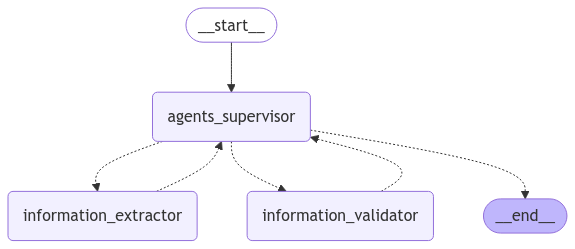

In [6]:
# Initialize the state graph with MessagesState
_logger.info("Setting up Graph")
builder = StateGraph(MessagesState)

# Add the starting edge from START to the supervisor node
builder.add_edge(START, "agents_supervisor")

# Define the processing nodes
builder.add_node("agents_supervisor", agents_supervisor_node)
builder.add_node("information_extractor", information_extractor_node)
builder.add_node("information_validator", information_validator_node)

# Graph execution configuration
config = {"recursion_limit": 10}

# Compile the state graph
graph = builder.compile()
_logger.info("Graph set up")

display(Image(graph.get_graph().draw_mermaid_png()))

## Orchestrating the Processing Workflow  
The `main()` function organizes the workflow for processing PDFs in Google Cloud.  

General flow:  
1. Download the PDF from Google Cloud Storage.  
2. Detect whether the document is digital or scanned.  
3. Apply text extraction using OCR or direct reading.  
4. Process the text with AI models to structure the information.  
5. Validate and correct the extracted data.  
6. Save results in Google Cloud Storage as `.txt` and `.json` files.  

Final output:  
- A `.txt` file containing the PDF content.  
- A `.json` file with structured information. 

In [7]:
def main(pdf_path):
    """
    Orchestrates the entire PDF processing workflow.

    Steps:
    1. Extracts text from the given PDF file stored in the GCS bucket.
    2. Processes the extracted text through the defined state graph.
    3. Collects messages from the processing pipeline.
    4. Uploads the final validated JSON output to GCS.

    Args:
        pdf_path (str): The file path of the PDF within the GCS bucket.

    Raises:
        Exception: If an error occurs during processing.

    """
    try:
        list_messages = []
        text = extract_text_from_pdf(pdf_path)

        for s in graph.stream(
            {"messages": [HumanMessage(content=text)]},
            subgraphs=True,
            config=config
        ):
            list_messages.append(s)

    except Exception:
        # Log de error o exception
        _logger.exception("Error retrieving message data")
        return  # Stop execution if there's a critical error

    finally:
        # Ensure at least two elements exist before processing the validator's message
        if len(list_messages) >= 2:
            try:
                mensaje = list_messages[-2][-1]["information_validator"]["messages"][0].content
                upload_json_to_gcs(mensaje, pdf_path)
            except (IndexError, KeyError, TypeError):
                # Log de error o exception
                _logger.exception("Error accessing the validation message data")


# Usage
pdf_path = "archivos/plantilla-nota-simple-5.pdf"
main(pdf_path)

2025-02-05 12:15:59,072 - __main__ - INFO - Downloading PDF from: archivos/plantilla-nota-simple-5.pdf
2025-02-05 12:15:59,395 - __main__ - INFO - Downloaded PDF from: archivos/plantilla-nota-simple-5.pdf
2025-02-05 12:15:59,396 - __main__ - INFO - Processing PDF: archivos/plantilla-nota-simple-5.pdf
2025-02-05 12:15:59,401 - __main__ - INFO - Detected scanned PDF, using OCR: archivos/plantilla-nota-simple-5.pdf
2025-02-05 12:15:59,586 - __main__ - INFO - Extracting page: 1 (OCR) ...
2025-02-05 12:16:10,462 - __main__ - INFO - Uploading text to: bucket-grupo4-cxb/textos/plantilla-nota-simple-5/pagina_1.txt
2025-02-05 12:16:10,763 - __main__ - INFO - Uploaded text to: bucket-grupo4-cxb/textos/plantilla-nota-simple-5/pagina_1.txt
2025-02-05 12:16:10,764 - __main__ - INFO - Extraction done (OCR)
2025-02-05 12:16:10,765 - __main__ - INFO - Uploading text to: bucket-grupo4-cxb/textos/plantilla-nota-simple-5/completo.txt
2025-02-05 12:16:11,059 - __main__ - INFO - Uploaded text to: bucket-gr